<a href="https://colab.research.google.com/github/achmadbauravindah/Auto-Line-Annotation-CXR/blob/master/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: RBP Classification Benchmark

### _by Achmad Bauravindah - 202526550_

This notebook implements and compares:
- k-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Sparse Representation-based Classifier (SRC)

Using:
- Stratified 5-Fold Cross-Validation
- Fold-wise reporting for Accuracy, MCC, AUC, and F1-score
- Averaged AUC-ROC curves across folds
- Summary comparison table and mean F1-score bar plot


### Import Libraries


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.linear_model import orthogonal_mp_gram
from sklearn.decomposition import SparseCoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

plt.style.use("seaborn-v0_8-whitegrid")
np.random.seed(42)




### Set Configurations


In [ ]:
DATA_DIR = "Datasets"
RBP_NAME = "ALL"  # Options: "ALKBH5", "ELAVL1", "ALL"
SPLITS_TO_USE = ("train",)
N_SPLITS = 5
RANDOM_STATE = 42

# SRC configuration (kept moderate for runtime)
SRC_MAX_SAMPLES_PER_CLASS = 250
SRC_N_NONZERO_COEFS = 35

if RBP_NAME == "ALL":
    TARGET_RBPS = ("ALKBH5", "ELAVL1")
else:
    TARGET_RBPS = (RBP_NAME,)

print("Available FASTA files:")
for f in sorted(os.listdir(DATA_DIR)):
    print(" -", f)

print("\nDatasets selected:", TARGET_RBPS)


Available FASTA files:
 - .ipynb_checkpoints
 - ALKBH5_Baltz2012.test.positives.fasta
 - ALKBH5_Baltz2012.test_negatives.fasta
 - ALKBH5_Baltz2012.train.negatives.fasta
 - ALKBH5_Baltz2012.train.positives.fasta
 - CLIPSEQ_ELAVL1.test.negatives.fasta
 - CLIPSEQ_ELAVL1.test.positives.fasta
 - CLIPSEQ_ELAVL1.train.negatives.fasta
 - CLIPSEQ_ELAVL1.train.positives.fasta

Datasets selected: ('ALKBH5', 'ELAVL1')


### FASTA Loading + One-Hot Encoding


In [ ]:
def load_fasta_set(folder, rbp_name, split_keyword, class_keyword):
    """
    split_keyword: 'train' or 'test'
    class_keyword: 'positives' or 'negatives'
    Returns: sequences(list[str]), labels(list[int])
    """
    seqs, labels = [], []
    matching_files = sorted(
        x for x in os.listdir(folder)
        if (rbp_name in x and split_keyword in x and class_keyword in x and x.endswith(".fasta"))
    )

    if not matching_files:
        raise FileNotFoundError(
            f"No FASTA files found for rbp={rbp_name}, split={split_keyword}, class={class_keyword}."
        )

    for single_file in matching_files:
        print("Processing file...", single_file)
        with open(os.path.join(folder, single_file), "r") as f:
            for line in f:
                if line.startswith(">"):
                    continue
                seqs.append(line.strip())
                labels.append(1 if "positives" in single_file else 0)

    return seqs, labels


def load_split_data(folder, rbp_name, split_keyword="train"):
    pos_seq, pos_label = load_fasta_set(folder, rbp_name, split_keyword, "positives")
    neg_seq, neg_label = load_fasta_set(folder, rbp_name, split_keyword, "negatives")

    all_sequences = pos_seq + neg_seq
    all_labels = np.array(pos_label + neg_label, dtype=np.int64)
    return all_sequences, all_labels


def convert2onehot(sequence_list):
    mapping = {
        "A": [1, 0, 0, 0],
        "U": [0, 1, 0, 0],
        "T": [0, 1, 0, 0],
        "G": [0, 0, 1, 0],
        "C": [0, 0, 0, 1],
    }

    lengths = {len(seq) for seq in sequence_list}
    if len(lengths) != 1:
        raise ValueError("All sequences must have the same length for flattening.")

    onehot = []
    for seq in sequence_list:
        onehot.append([mapping.get(ch.upper(), [0, 0, 0, 0]) for ch in seq])

    return np.asarray(onehot, dtype=np.float32)  # (N, L, 4)


def to_2d_features(onehot_3d):
    # (N, L, 4) -> (N, L*4)
    return onehot_3d.reshape(onehot_3d.shape[0], -1)


def load_feature_matrix(folder, rbp_name, split_keyword="train"):
    seqs, y = load_split_data(folder, rbp_name, split_keyword=split_keyword)
    X = to_2d_features(convert2onehot(seqs))
    return X, y


### SRC Classifier


In [ ]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import solve
from sklearn.base import BaseEstimator, ClassifierMixin


def OrthogonalMP(A, b, tol=1E-4, nnz=None, positive=False):
    AT = A.T
    d, n = A.shape
    if nnz is None:
        nnz = n
    x = np.zeros(n)
    resid = np.copy(b)
    normb = norm(b)
    indices = []

    for i in range(nnz):
        if norm(resid) / normb < tol:
            break
        projections = AT.dot(resid)
        if positive:
            index = np.argmax(projections)
        else:
            index = np.argmax(abs(projections))
        if index in indices:
            break
        indices.append(index)
        if len(indices) == 1:
            A_i = A[:, index]
            x_i = projections[index] / A_i.T.dot(A_i)
        else:
            A_i = np.vstack([A_i, A[:, index]])
            x_i = solve(A_i.dot(A_i.T), A_i.dot(b), assume_a='sym')
            if positive:
                while min(x_i) < 0.0:
                    argmin = np.argmin(x_i)
                    indices = indices[:argmin] + indices[argmin + 1:]
                    A_i = np.vstack([A_i[:argmin], A_i[argmin + 1:]])
                    x_i = solve(A_i.dot(A_i.T), A_i.dot(b), assume_a='sym')
        resid = b - A_i.T.dot(x_i)

    for i, index in enumerate(indices):
        try:
            x[index] += x_i[i]
        except IndexError:
            x[index] += x_i
    return x


def delta_rule(A, delta_y, x, b):
    delta1 = 0 * x
    delta2 = 0 * x
    delta1[delta_y == 1] = x[delta_y == 1]
    delta2[delta_y == 0] = x[delta_y == 0]
    y1 = np.matmul(A, delta1)
    y2 = np.matmul(A, delta2)
    r1 = np.linalg.norm(y1 - b)
    r2 = np.linalg.norm(y2 - b)

    if r1 < r2:
        label = 1
    else:
        label = 0
    score = (r2) / (r1 + r2 + 1e-30)
    return label, score


def Test_SRC(A, delta_y, DATA, LABEL, solver='OP', verbose=0,
             x0=None, ATinvAAT=None, nnz=None, positive=False,
             tol=1E-4, niter=100, biter=32):
    import time
    LABEL_PRED = []
    SCORE_PRED = []
    count = 0
    time_ellapsed = []

    for ind in range(0, DATA.shape[1]):
        start_time = time.time()
        b = DATA[:, ind]

        if solver == "OP":
            x = OrthogonalMP(A, b, tol=tol, nnz=nnz, positive=positive)
        else:
            raise ValueError("This minimal integration supports solver='OP' only.")

        label_out, score_out = delta_rule(A, delta_y, x, b)
        time_ellapsed.append(time.time() - start_time)

        if verbose:
            check = label_out == LABEL[ind]
            if check:
                count = count + 1
            accuracy = 100 * count / (ind + 1)
            print(ind + 1, count, accuracy, LABEL[ind], label_out, check)

        LABEL_PRED.append(label_out)
        SCORE_PRED.append(score_out)

    return np.array(LABEL_PRED), np.array(SCORE_PRED), np.array(time_ellapsed)


class ACPSRCClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, solver='OP', nnz=35, positive=True, tol=1E-4, niter=100, biter=32, verbose=0):
        self.solver = solver
        self.nnz = nnz
        self.positive = positive
        self.tol = tol
        self.niter = niter
        self.biter = biter
        self.verbose = verbose

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).astype(int)

        uniq = np.unique(y)
        if uniq.shape[0] != 2 or np.setdiff1d(uniq, [0, 1]).size > 0:
            raise ValueError("ACPSRCClassifier expects binary labels {0,1}.")

        self.classes_ = np.array([0, 1])
        self.A_ = X.T
        self.delta_y_ = y
        return self

    def _predict_raw(self, X):
        X = np.asarray(X, dtype=np.float64)
        dummy = np.zeros(X.shape[0], dtype=int)
        y_pred, y_score, _ = Test_SRC(
            A=self.A_,
            delta_y=self.delta_y_,
            DATA=X.T,
            LABEL=dummy,
            solver=self.solver,
            verbose=self.verbose,
            nnz=self.nnz,
            positive=self.positive,
            tol=self.tol,
            niter=self.niter,
            biter=self.biter,
        )
        return y_pred.astype(int), y_score.astype(float)

    def predict(self, X):
        y_pred, _ = self._predict_raw(X)
        return y_pred

    def predict_proba(self, X):
        _, score1 = self._predict_raw(X)
        p1 = np.clip(score1, 0.0, 1.0)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def decision_function(self, X):
        _, score1 = self._predict_raw(X)
        return score1 - 0.5

### Cross-Validation and Evaluation Utilities


In [ ]:
def get_positive_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return np.ravel(scores)
    raise AttributeError("Model must expose predict_proba or decision_function for ROC-AUC.")


def evaluate_model_cv(model, X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_rows = []
    mean_fpr = np.linspace(0.0, 1.0, 200)
    tprs = []
    auc_values = []

    for fold_id, (train_idx, valid_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model_fold = clone(model)
        model_fold.fit(X_train, y_train)

        y_pred = model_fold.predict(X_valid)
        y_score = get_positive_scores(model_fold, X_valid)

        fold_acc = accuracy_score(y_valid, y_pred)
        fold_mcc = matthews_corrcoef(y_valid, y_pred)
        fold_f1 = f1_score(y_valid, y_pred)
        fold_auc = roc_auc_score(y_valid, y_score)

        fpr, tpr, _ = roc_curve(y_valid, y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_values.append(fold_auc)

        fold_rows.append(
            {
                "fold": fold_id,
                "accuracy": fold_acc,
                "mcc": fold_mcc,
                "auc": fold_auc,
                "f1": fold_f1,
            }
        )

    fold_df = pd.DataFrame(fold_rows)
    roc_payload = {
        "mean_fpr": mean_fpr,
        "tprs": np.array(tprs),
        "auc_values": np.array(auc_values),
    }
    return fold_df, roc_payload

def summarize_results(fold_results_df):
    return (
        fold_results_df
        .groupby(["dataset", "model"], as_index=False)
        .agg(
            accuracy_mean=("accuracy", "mean"),
            auc_mean=("auc", "mean"),
            mcc_mean=("mcc", "mean"),
            f1_mean=("f1", "mean"),
        )
        .sort_values(["dataset", "f1_mean"], ascending=[True, False])
    )

def plot_roc_by_dataset(roc_results, dataset_name):
    plt.figure(figsize=(8, 6))

    for model_name, payload in roc_results[dataset_name].items():
        mean_fpr = payload["mean_fpr"]
        mean_tpr = payload["tprs"].mean(axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = payload["auc_values"].mean()
        std_auc = payload["auc_values"].std(ddof=1)

        plt.plot(
            mean_fpr,
            mean_tpr,
            linewidth=2,
            label=f"{model_name} (AUC={mean_auc:.3f}±{std_auc:.3f})",
        )

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Mean ROC Curves (5-Fold CV) - {dataset_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

def plot_f1_bar(summary_df):
    pivot_df = summary_df.pivot(index="model", columns="dataset", values="f1_mean")

    ax = pivot_df.plot(kind="bar", figsize=(9, 5), rot=0)
    ax.set_ylabel("Mean F1-score")
    ax.set_xlabel("Model")
    ax.set_title("Mean F1-score Comparison Across Models")
    plt.tight_layout()
    plt.show()

### Load Dataset Features


In [ ]:
dataset_data = {}

for rbp in TARGET_RBPS:
    X, y = load_feature_matrix(DATA_DIR, rbp, split_keyword="train")
    dataset_data[rbp] = {"X": X, "y": y}

    print(
        f"{rbp}: X shape={X.shape}, y shape={y.shape}, "
        f"positive ratio={y.mean():.3f}"
    )

Processing file... ALKBH5_Baltz2012.train.positives.fasta
Processing file... ALKBH5_Baltz2012.train.negatives.fasta
ALKBH5: X shape=(2361, 800), y shape=(2361,), positive ratio=0.499
Processing file... CLIPSEQ_ELAVL1.train.positives.fasta
Processing file... CLIPSEQ_ELAVL1.train.negatives.fasta
ELAVL1: X shape=(16550, 800), y shape=(16550,), positive ratio=0.495


### Define Models


In [ ]:
MODELS = {
    "KNN": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=9, weights="distance"),
    ),
    "SVM": make_pipeline(
        StandardScaler(),
        LinearSVC(C=1.0, dual="auto", max_iter=5000, random_state=RANDOM_STATE),
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "SRC": make_pipeline(
        StandardScaler(),
        ACPSRCClassifier(
            solver="OP",
            nnz=35,       # set None for fully exact ACP behavior (slower)
            positive=True,
            tol=1e-4,
        ),
    ),
}

print("Models ready:", list(MODELS.keys()))

Models ready: ['KNN', 'SVM', 'Random Forest', 'SRC']


### Run Stratified 5-Fold Cross-Validation


In [9]:
all_fold_results = []
roc_results = {dataset_name: {} for dataset_name in dataset_data.keys()}

for dataset_name, bundle in dataset_data.items():
    X, y = bundle["X"], bundle["y"]
    print(f"\nRunning on dataset: {dataset_name}")

    for model_name, model in MODELS.items():
        print(f"  -> Evaluating {model_name}")
        fold_df, roc_payload = evaluate_model_cv(
            model=model,
            X=X,
            y=y,
            n_splits=N_SPLITS,
            random_state=RANDOM_STATE,
        )

        fold_df.insert(0, "model", model_name)
        fold_df.insert(0, "dataset", dataset_name)

        all_fold_results.append(fold_df)
        roc_results[dataset_name][model_name] = roc_payload

fold_results_df = pd.concat(all_fold_results, ignore_index=True)
summary_df = summarize_results(fold_results_df)

print("\nEvaluation complete.")


Running on dataset: ALKBH5
  -> Evaluating KNN
  -> Evaluating SVM
  -> Evaluating Random Forest
  -> Evaluating SRC

Running on dataset: ELAVL1
  -> Evaluating KNN
  -> Evaluating SVM
  -> Evaluating Random Forest
  -> Evaluating SRC

Evaluation complete.

Evaluation complete.


### Fold-wise Results


In [10]:
for dataset_name in dataset_data.keys():
    print(f"\nFold metrics for {dataset_name}")
    display(
        fold_results_df[fold_results_df["dataset"] == dataset_name]
        .sort_values(["model", "fold"])
        .reset_index(drop=True)
    )


Fold metrics for ALKBH5

Fold metrics for ALKBH5


,dataset,model,fold,accuracy,mcc,auc,f1
0,ALKBH5,KNN,1,0.547569,0.095253,0.593658,0.554167
1,ALKBH5,KNN,2,0.557203,0.114408,0.588453,0.556263
2,ALKBH5,KNN,3,0.525424,0.050996,0.569018,0.506608
3,ALKBH5,KNN,4,0.574153,0.148619,0.614858,0.582121
4,ALKBH5,KNN,5,0.557203,0.114571,0.574055,0.532438
5,ALKBH5,Random Forest,1,0.564482,0.128955,0.603930,0.557940
6,ALKBH5,Random Forest,2,0.559322,0.119072,0.565023,0.539823
7,ALKBH5,Random Forest,3,0.555085,0.111196,0.596443,0.522727
8,ALKBH5,Random Forest,4,0.580508,0.160965,0.607101,0.575107
9,ALKBH5,Random Forest,5,0.582627,0.166381,0.606545,0.549199


,dataset,model,fold,accuracy,mcc,auc,f1
0,ALKBH5,KNN,1,0.547569,0.095253,0.593658,0.554167
1,ALKBH5,KNN,2,0.557203,0.114408,0.588453,0.556263
2,ALKBH5,KNN,3,0.525424,0.050996,0.569018,0.506608
3,ALKBH5,KNN,4,0.574153,0.148619,0.614858,0.582121
4,ALKBH5,KNN,5,0.557203,0.114571,0.574055,0.532438
5,ALKBH5,Random Forest,1,0.564482,0.128955,0.603930,0.557940
6,ALKBH5,Random Forest,2,0.559322,0.119072,0.565023,0.539823
7,ALKBH5,Random Forest,3,0.555085,0.111196,0.596443,0.522727
8,ALKBH5,Random Forest,4,0.580508,0.160965,0.607101,0.575107
9,ALKBH5,Random Forest,5,0.582627,0.166381,0.606545,0.549199



Fold metrics for ELAVL1

Fold metrics for ELAVL1


,dataset,model,fold,accuracy,mcc,auc,f1
0,ELAVL1,KNN,1,0.664048,0.437083,0.843451,0.744954
1,ELAVL1,KNN,2,0.662840,0.433332,0.852214,0.743919
2,ELAVL1,KNN,3,0.661934,0.432441,0.849766,0.743525
3,ELAVL1,KNN,4,0.670695,0.449817,0.853464,0.748964
4,ELAVL1,KNN,5,0.664048,0.435521,0.849808,0.744485
5,ELAVL1,Random Forest,1,0.928399,0.856786,0.975691,0.927545
6,ELAVL1,Random Forest,2,0.920846,0.841702,0.971038,0.919681
7,ELAVL1,Random Forest,3,0.926284,0.852793,0.976007,0.924598
8,ELAVL1,Random Forest,4,0.938369,0.876733,0.980072,0.937538
9,ELAVL1,Random Forest,5,0.923565,0.847134,0.971620,0.922416


,dataset,model,fold,accuracy,mcc,auc,f1
0,ELAVL1,KNN,1,0.664048,0.437083,0.843451,0.744954
1,ELAVL1,KNN,2,0.662840,0.433332,0.852214,0.743919
2,ELAVL1,KNN,3,0.661934,0.432441,0.849766,0.743525
3,ELAVL1,KNN,4,0.670695,0.449817,0.853464,0.748964
4,ELAVL1,KNN,5,0.664048,0.435521,0.849808,0.744485
5,ELAVL1,Random Forest,1,0.928399,0.856786,0.975691,0.927545
6,ELAVL1,Random Forest,2,0.920846,0.841702,0.971038,0.919681
7,ELAVL1,Random Forest,3,0.926284,0.852793,0.976007,0.924598
8,ELAVL1,Random Forest,4,0.938369,0.876733,0.980072,0.937538
9,ELAVL1,Random Forest,5,0.923565,0.847134,0.971620,0.922416


### Summary Table (Mean Metrics Across 5 Folds)


In [11]:
display(summary_df.reset_index(drop=True))

,dataset,model,accuracy_mean,auc_mean,mcc_mean,f1_mean
0,ALKBH5,SRC,0.587467,0.613546,0.175326,0.588953
1,ALKBH5,Random Forest,0.568405,0.595808,0.137314,0.548959
2,ALKBH5,KNN,0.552310,0.588008,0.104769,0.546319
3,ALKBH5,SVM,0.541286,0.557215,0.082655,0.542467
4,ELAVL1,Random Forest,0.927492,0.974886,0.855029,0.926356
5,ELAVL1,SVM,0.912326,0.967417,0.824940,0.912402
6,ELAVL1,SRC,0.853293,0.929176,0.706587,0.852101
7,ELAVL1,KNN,0.664713,0.849741,0.437639,0.745169


,dataset,model,accuracy_mean,auc_mean,mcc_mean,f1_mean
0,ALKBH5,SRC,0.587467,0.613546,0.175326,0.588953
1,ALKBH5,Random Forest,0.568405,0.595808,0.137314,0.548959
2,ALKBH5,KNN,0.552310,0.588008,0.104769,0.546319
3,ALKBH5,SVM,0.541286,0.557215,0.082655,0.542467
4,ELAVL1,Random Forest,0.927492,0.974886,0.855029,0.926356
5,ELAVL1,SVM,0.912326,0.967417,0.824940,0.912402
6,ELAVL1,SRC,0.853293,0.929176,0.706587,0.852101
7,ELAVL1,KNN,0.664713,0.849741,0.437639,0.745169


### Averaged ROC Curves


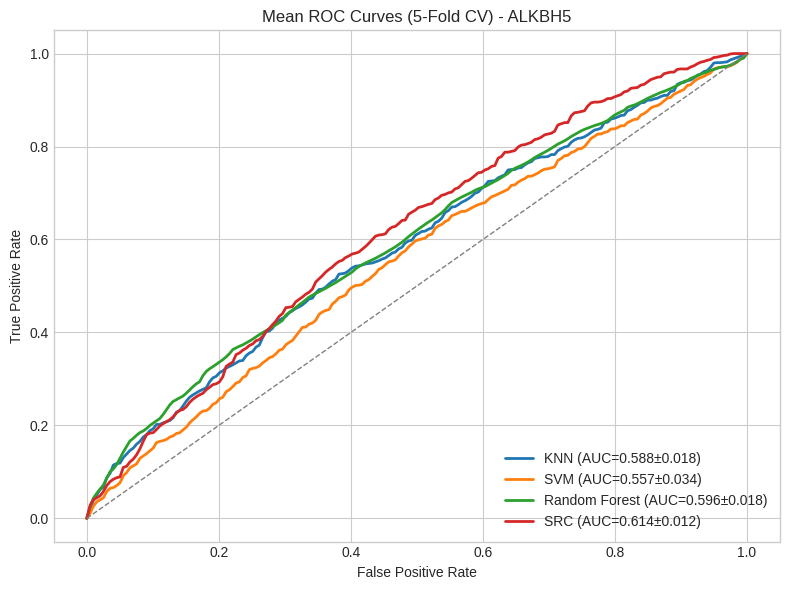

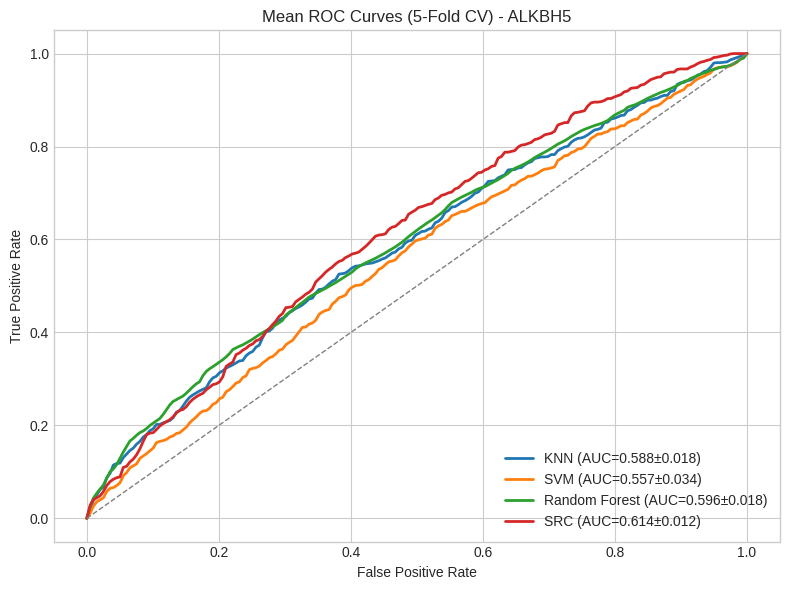

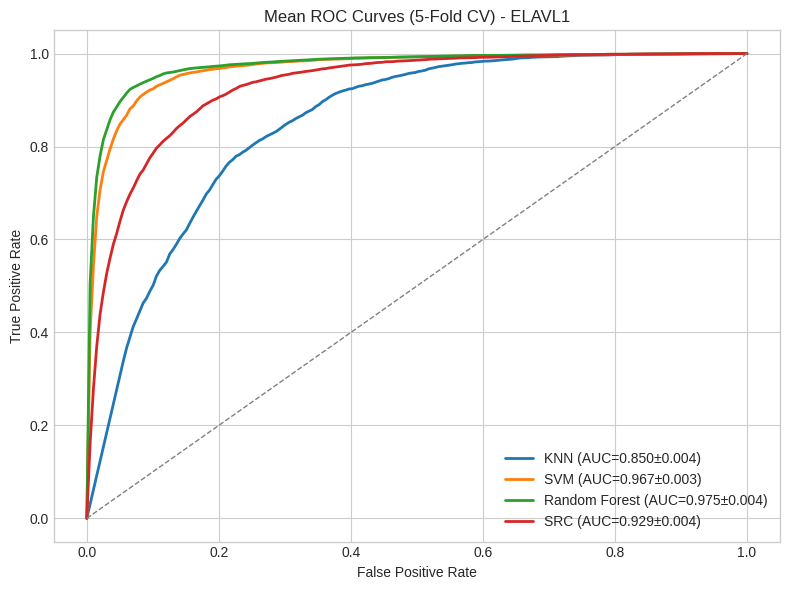

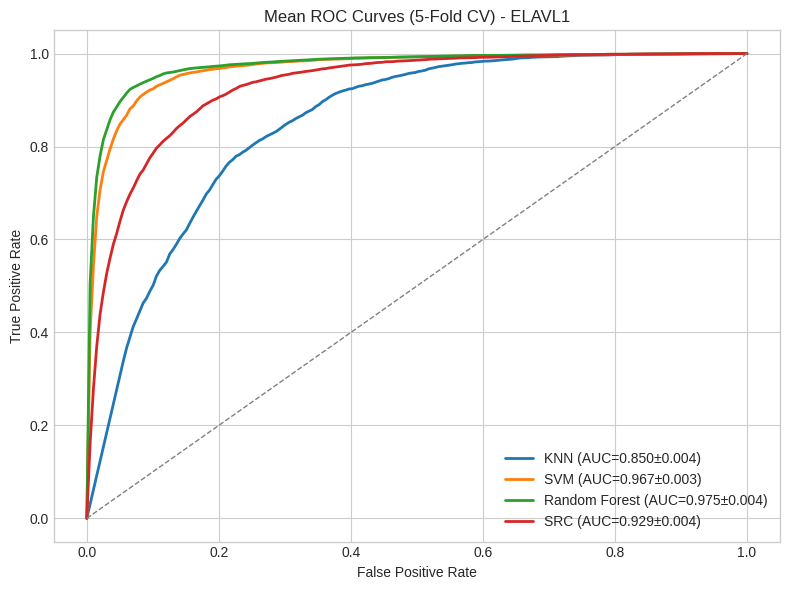

In [12]:
for dataset_name in dataset_data.keys():
    plot_roc_by_dataset(roc_results, dataset_name)


### Mean F1-Score Bar Plot


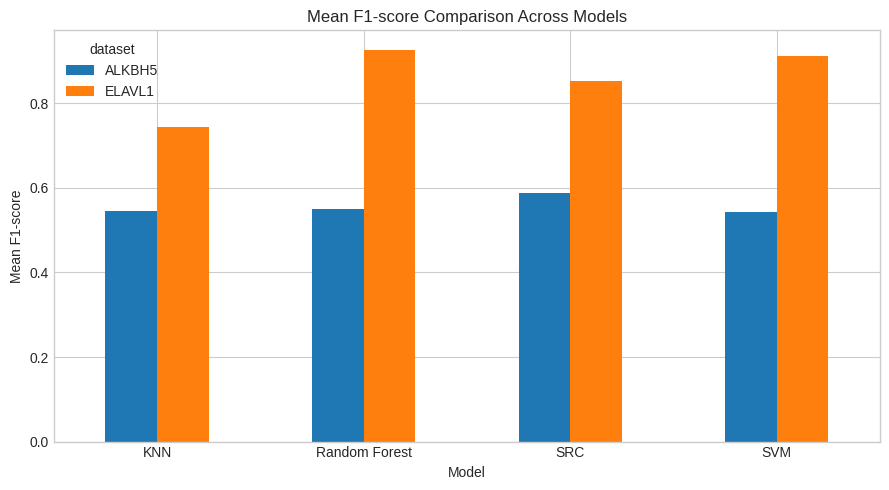

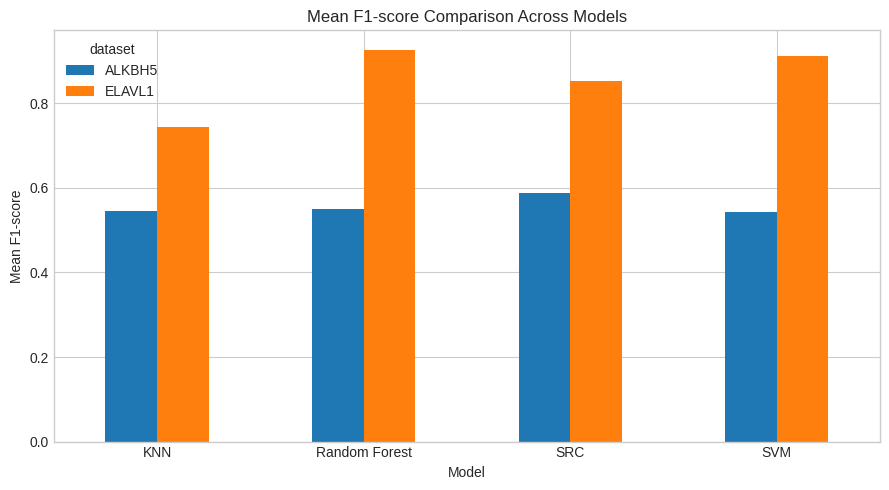

In [13]:
plot_f1_bar(summary_df)